#### Predict Heart Attack
#### Dataset: https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mutual_info_score
)
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import pickle

%matplotlib inline

### A. Data preparation and data cleaning
* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split


In [4]:
data_path = './Student_performance_data.csv'
df = pd.read_csv(data_path)

In [202]:
# See shape
print("Shape:", df.shape)

# View all column names
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

df.columns = df.columns.str.lower()
df.columns

Shape: (2392, 15)


Index(['studentid', 'age', 'gender', 'ethnicity', 'parentaleducation',
       'studytimeweekly', 'absences', 'tutoring', 'parentalsupport',
       'extracurricular', 'sports', 'music', 'volunteering', 'gpa',
       'gradeclass'],
      dtype='object')

In [203]:
df.isnull().sum()

studentid            0
age                  0
gender               0
ethnicity            0
parentaleducation    0
studytimeweekly      0
absences             0
tutoring             0
parentalsupport      0
extracurricular      0
sports               0
music                0
volunteering         0
gpa                  0
gradeclass           0
dtype: int64

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   studentid          2392 non-null   int64  
 1   age                2392 non-null   int64  
 2   gender             2392 non-null   int64  
 3   ethnicity          2392 non-null   int64  
 4   parentaleducation  2392 non-null   int64  
 5   studytimeweekly    2392 non-null   float64
 6   absences           2392 non-null   int64  
 7   tutoring           2392 non-null   int64  
 8   parentalsupport    2392 non-null   int64  
 9   extracurricular    2392 non-null   int64  
 10  sports             2392 non-null   int64  
 11  music              2392 non-null   int64  
 12  volunteering       2392 non-null   int64  
 13  gpa                2392 non-null   float64
 14  gradeclass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


In [205]:
del df['studentid']

df.head()

,age,gender,ethnicity,parentaleducation,studytimeweekly,absences,tutoring,parentalsupport,extracurricular,sports,music,volunteering,gpa,gradeclass
0,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [206]:
# Define mapping dictionaries
gender_map = {0: 'Male', 1: 'Female'}

ethnicity_map = {
    0: 'Caucasian',
    1: 'African American',
    2: 'Asian',
    3: 'Other'
}

parental_edu_map = {
    0: 'None',
    1: 'High School',
    2: 'Some College',
    3: "Bachelor's",
    4: 'Higher'
}

parental_support_map = {
    0: 'None',
    1: 'Low',
    2: 'Moderate',
    3: 'High',
    4: 'Very High'
}

grade_class_map = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'F'
}

tutoring_map = {0: 'No', 1: 'Yes'}
extracurricular_map = {0: 'No', 1: 'Yes'}
sports_map = {0: 'No', 1: 'Yes'}
music_map = {0: 'No', 1: 'Yes'}
volunteering_map = {0: 'No', 1: 'Yes'}

# Apply mappings safely using bracket notation
df['gender'] = df['gender'].map(gender_map)
df['ethnicity'] = df['ethnicity'].map(ethnicity_map)
df['parentaleducation'] = df['parentaleducation'].map(parental_edu_map)
df['parentalsupport'] = df['parentalsupport'].map(parental_support_map)
df['gradeclass'] = df['gradeclass'].map(grade_class_map)
df['tutoring'] = df['tutoring'].map(tutoring_map)
df['extracurricular'] = df['extracurricular'].map(extracurricular_map)
df['sports'] = df['sports'].map(sports_map)
df['music'] = df['music'].map(music_map)
df['volunteering'] = df['volunteering'].map(volunteering_map)



In [207]:
# Remove GPA to prevent data leakage
# The target variable 'GradeClass' is derived directly from 'GPA' (e.g., A: GPA ≥ 3.5, B: 3.0–3.49, etc.).
# Keeping GPA as a feature would allow the model to "cheat" by learning a near-perfect mapping to GradeClass,
# resulting in unrealistically high accuracy and poor generalization.
# Therefore, GPA is dropped to ensure the model learns from independent predictors only.
del df['gpa']

In [208]:
df.head()

,age,gender,ethnicity,parentaleducation,studytimeweekly,absences,tutoring,parentalsupport,extracurricular,sports,music,volunteering,gradeclass
0,17,Female,Caucasian,Some College,19.833723,7,Yes,Moderate,No,No,Yes,No,C
1,18,Male,Caucasian,High School,15.408756,0,No,Low,No,No,No,No,B
2,15,Male,Asian,Bachelor's,4.210570,26,No,Moderate,No,No,No,No,F
3,17,Female,Caucasian,Bachelor's,10.028829,14,No,High,Yes,No,No,No,D
4,17,Female,Caucasian,Some College,4.672495,17,Yes,High,No,No,No,No,F


In [209]:
# Numerical features
num_cols = ['age', 'studytimeweekly', 'absences']

# Categorical features (excluding target)
cat_cols = [
    'gender', 'ethnicity', 'parentaleducation', 'tutoring',
    'parentalsupport', 'extracurricular', 'sports', 'music', 'volunteering'
]

### B. EDA, feature importance analysis

#### Target Variable Distribution

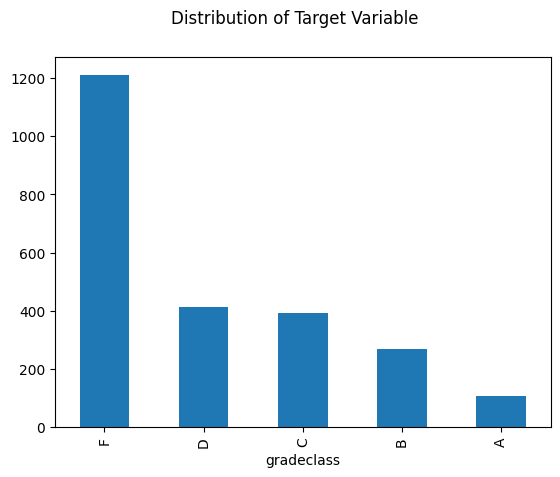

In [210]:
df['gradeclass'].value_counts().plot(kind='bar')
plt.suptitle("Distribution of Target Variable", fontsize=12)
plt.show()

#### Numerical Feature Distributions

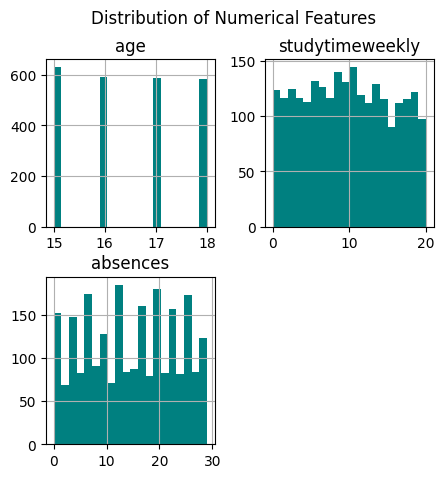

In [211]:
# Plot distributions
df[num_cols].hist(figsize=(5, 5), bins=20, color='teal')
plt.suptitle("Distribution of Numerical Features", fontsize=12)
plt.show()

#### Categorical Feature Distributions


gender: 2 unique values


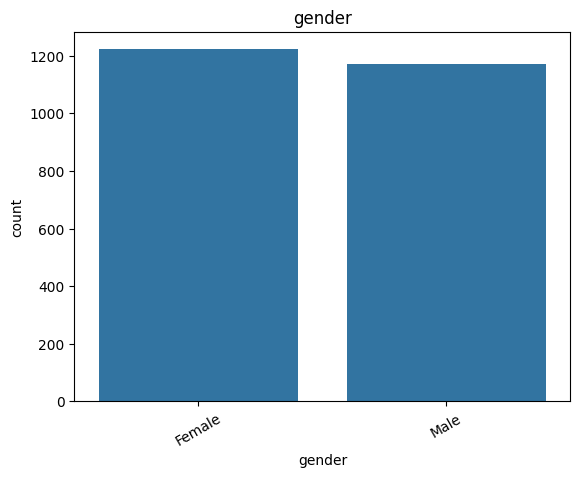


ethnicity: 4 unique values


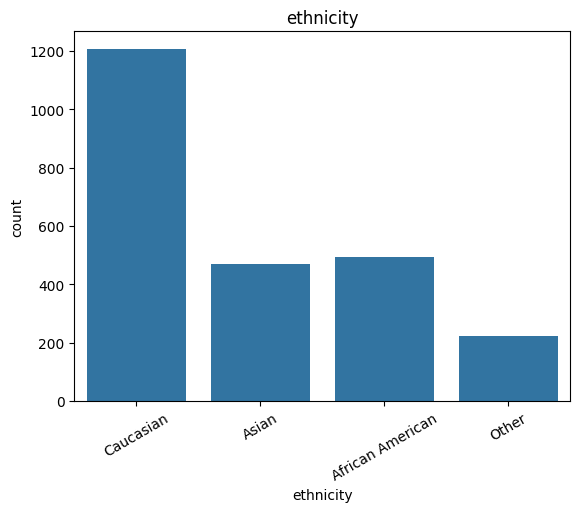


parentaleducation: 5 unique values


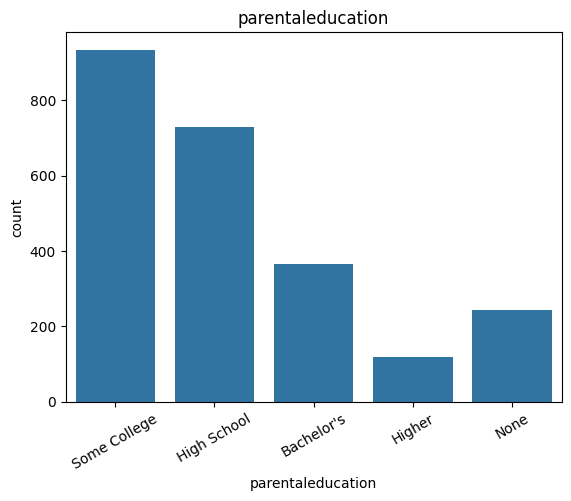


tutoring: 2 unique values


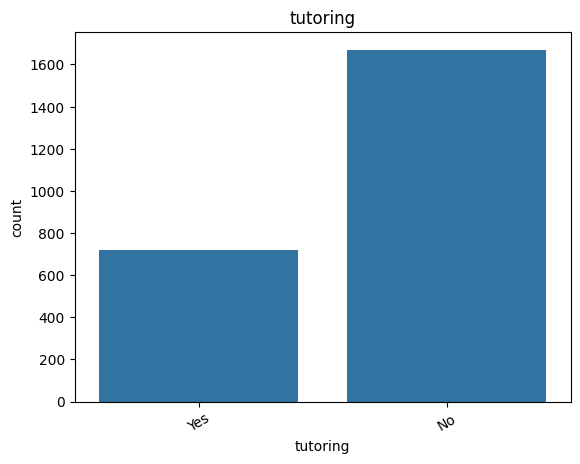


parentalsupport: 5 unique values


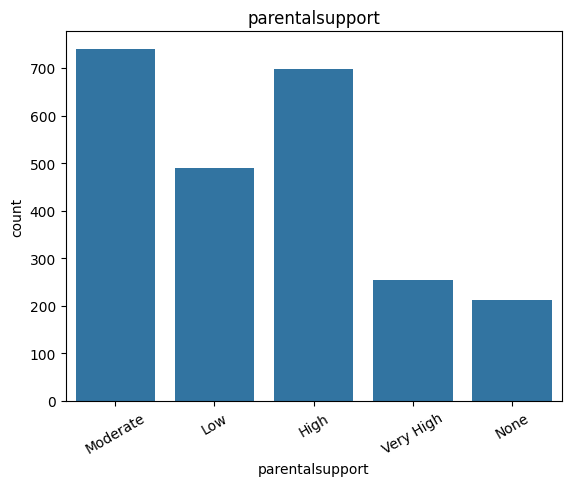


extracurricular: 2 unique values


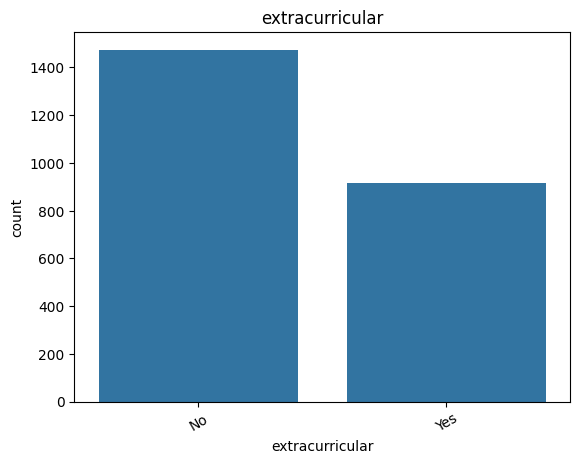


sports: 2 unique values


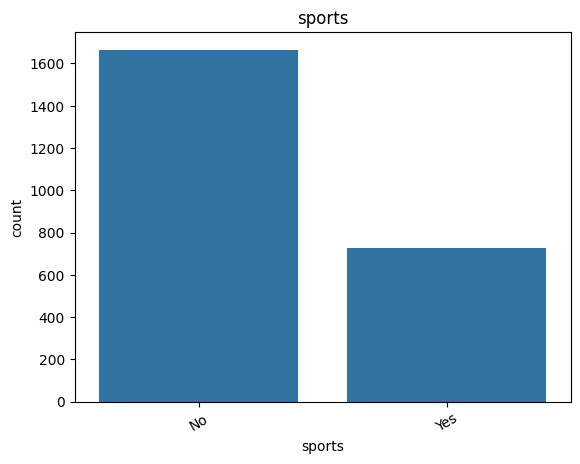


music: 2 unique values


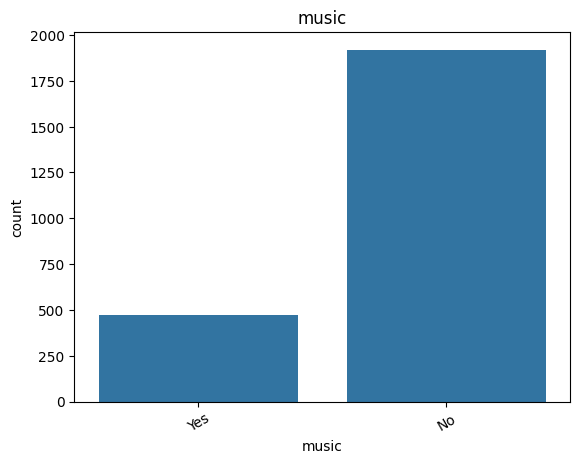


volunteering: 2 unique values


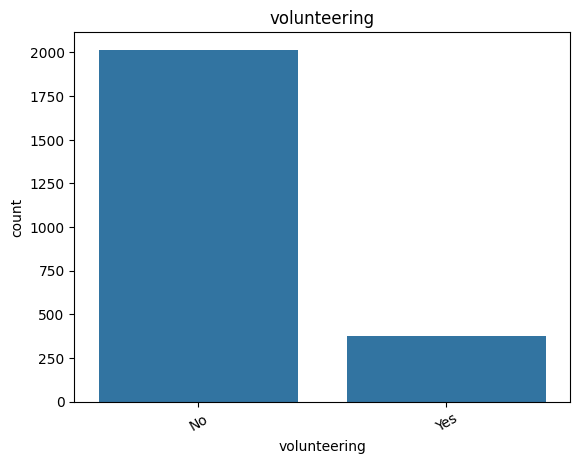

In [212]:
for col in cat_cols:
    unique_count = df[col].nunique()
    print(f"\n{col}: {unique_count} unique values")

    if unique_count <= 10:
        sns.countplot(x=col, data=df)
        plt.title(f"{col}")
        plt.xticks(rotation=30)
        plt.show()
    else:
        print(f"⚠️ Skipping {col} (too many unique values)")

#### Setting up the validation framework

In [213]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.gradeclass.values
y_val = df_val.gradeclass.values
y_test = df_test.gradeclass.values

del df_train['gradeclass']
del df_val['gradeclass']
del df_test['gradeclass']

In [214]:
df_train.head()

,age,gender,ethnicity,parentaleducation,studytimeweekly,absences,tutoring,parentalsupport,extracurricular,sports,music,volunteering
0,15,Male,African American,Some College,19.293810,14,No,High,Yes,Yes,No,No
1,16,Female,Caucasian,Some College,18.380766,29,No,Very High,No,No,No,No
2,18,Female,Asian,Some College,0.260204,15,No,High,Yes,Yes,Yes,No
3,17,Male,African American,High School,1.573972,6,No,None,No,No,Yes,No
4,15,Male,Caucasian,Bachelor's,4.997349,27,No,Moderate,Yes,No,No,No


#### feature importance analysis

##### Mutual Information (Categorical Features)

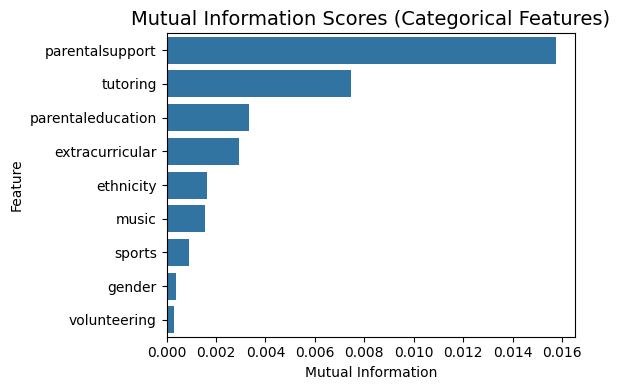

In [215]:
def mutual_info(series):
    return mutual_info_score(series, df.gradeclass.values)

mi = df[cat_cols].apply(mutual_info)
mi_sorted = mi.sort_values(ascending=False)
mi_df = mi_sorted.reset_index()
mi_df.columns = ['Feature', 'Mutual Information']

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=mi_df, x='Mutual Information', y='Feature')
plt.title('Mutual Information Scores (Categorical Features)', fontsize=14)
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



The mutual information (MI) scores show how much each **categorical feature** contributes to predicting the target variable (`gradeclass`).

- `parentalsupport` has the **strongest relationship** with academic performance, meaning higher parental involvement tends to correlate with better grades.  
- `tutoring` also provides moderate predictive power — students who receive tutoring often perform better academically.  
- Other features like `parentaleducation`, `extracurricular`, and `ethnicity` contribute slightly but are relatively weak indicators.  

Overall, most categorical variables exhibit **low mutual information**, suggesting weak direct relationships with grade outcomes.

##### Pearson Correlation : Numerical features

/tmp/ipykernel_2486/124459540.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')


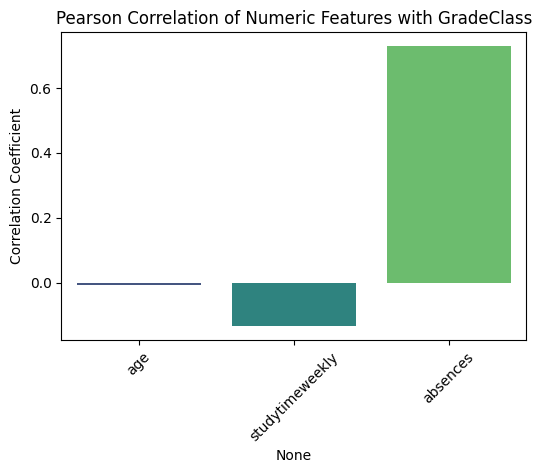

In [216]:
# Encode the gradeclass into numerical form
grade_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'F': 4}
df['grade_numeric'] = df['gradeclass'].map(grade_mapping)

# Compute correlation between numeric features and target
correlations = df[num_cols].apply(lambda x: x.corr(df['grade_numeric']))

# Sort and plot
plt.figure(figsize=(6,4))
sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')
plt.title("Pearson Correlation of Numeric Features with GradeClass")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)
plt.show()

# Delete the temporary numeric grade column
del df['grade_numeric']

The bar plot shows the **Pearson correlation** between numeric features and `gradeclass`.  
It reveals how each variable relates linearly to students’ grades.

- **Absences** show a **strong positive correlation**, meaning more absences are linked to **worse grades**.  
- **Study time** shows a **weak negative correlation**, suggesting that studying more slightly improves performance.  
- **Age** has **no clear correlation**, indicating it’s not related to grade outcomes.

Overall, **absences** are the most influential factor associated with grade performance.

### C. Model selection process and parameter tuning

#### Model Selection

In [217]:
final_results = []

In [218]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

dv = DictVectorizer(sparse=False)
X_val = dv.fit_transform(val_dicts)

##### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred_val = lr.predict(X_val)

# --- Multi-class evaluation metrics ---
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_val, y_pred_val, average='macro')
f1 = f1_score(y_val, y_pred_val, average='macro')

# --- Store results in a table ---
final_results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Decision Tree Model

In [220]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_val = dt.predict(X_val)

# --- Multi-class evaluation metrics ---
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_val, y_pred_val, average='macro')
f1 = f1_score(y_val, y_pred_val, average='macro')

# --- Store results in a table ---
final_results.append({
    "Model": "Decision Tree",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

##### Random Forest

In [221]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

y_pred_val = model_rf.predict(X_val)

# --- Multi-class evaluation metrics ---
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_val, y_pred_val, average='macro')
f1 = f1_score(y_val, y_pred_val, average='macro')

# --- Store results in a table ---
final_results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

In [222]:
results_df = pd.DataFrame(final_results)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.713987,0.571522,0.532455,0.542164
1,Decision Tree,0.609603,0.421748,0.427754,0.423769
2,Random Forest,0.716075,0.583720,0.522654,0.534710


#### Hyperparameter Tuning  

In this section, we fine-tune the hyperparameters of Logistic Regression, Decision Tree, Random Forest using Grid Search to improve accuracy, precision, recall, and F1-score.


##### Logistic Regression

In [223]:
param_grid_lr = {
    'C': [0.005, 0.01, 0.1, 1, 5],
    'max_iter': [500, 1000,1500],
    'class_weight': ['balanced', None]
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid=param_grid_lr,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

# --- Evaluate tuned Logistic Regression ---
y_pred_lr = best_lr.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_lr)
precision = precision_score(y_val, y_pred_lr, average='macro')
recall = recall_score(y_val, y_pred_lr, average='macro')
f1 = f1_score(y_val, y_pred_lr, average='macro')

final_results.append({
    "Model": "Logistic Regression (Tuned)",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

#### Decision Tree

In [225]:
# --- Define parameter grid for Decision Tree ---
param_grid_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# --- Perform Grid Search with Cross-Validation ---
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

# --- Evaluate tuned Decision Tree ---
y_pred_dt = best_dt.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_dt)
precision = precision_score(y_val, y_pred_dt, average='macro')
recall = recall_score(y_val, y_pred_dt, average='macro')
f1 = f1_score(y_val, y_pred_dt, average='macro')

# --- Store results ---
final_results.append({
    "Model": "Decision Tree (Tuned)",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

#### Random Forest

In [226]:
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "max_features": ["sqrt", "log2"],
    "class_weight": [None, "balanced", "balanced_subsample"]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# --- Evaluate tuned Random Forest ---
y_pred_rf = best_rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_rf)
precision = precision_score(y_val, y_pred_rf, average='macro')
recall = recall_score(y_val, y_pred_rf, average='macro')
f1 = f1_score(y_val, y_pred_rf, average='macro')

final_results.append({
    "Model": "Random Forest (Tuned)",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [227]:
final_results_df = pd.DataFrame(final_results)
final_results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.713987,0.571522,0.532455,0.542164
1,Decision Tree,0.609603,0.421748,0.427754,0.423769
2,Random Forest,0.716075,0.583720,0.522654,0.534710
3,Logistic Regression (Tuned),0.705637,0.572069,0.523044,0.532744
4,Decision Tree (Tuned),0.592902,0.465673,0.485959,0.452277
5,Random Forest (Tuned),0.674322,0.517322,0.493187,0.493266


#### Select the final model

The table above compares model performance (Accuracy, Precision, Recall, F1 Score) before and after hyperparameter tuning.

- **Logistic Regression (default)** achieved the **best overall performance** with the highest accuracy (≈0.714) and balanced precision/recall values.
- **Decision Tree** and **Random Forest** models showed lower overall scores, even after fine-tuning.
- Notably, **tuning did not improve performance** — both Logistic Regression (Tuned) and Random Forest (Tuned) performed slightly worse than their default versions.

**Conclusion:**  
The **original Logistic Regression model (default parameters)** remains the **best-performing model** in terms of both accuracy and generalization, suggesting that its default regularization and simplicity suit the dataset well.


In [229]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred= lr.predict(X_val)

# --- Multi-class evaluation metrics ---
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_val, y_pred_val, average='macro')
f1 = f1_score(y_val, y_pred_val, average='macro')

print({
    'Model': 'Logistic Regression',
    'Accuracy': round(accuracy, 4),
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4)
})

{'Model': 'Logistic Regression', 'Accuracy': 0.7161, 'Precision': 0.5837, 'Recall': 0.5227, 'F1 Score': 0.5347}


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
